# Deep Learning Project - Potato Disease🥔🍃

Human society needs to increase food production by an estimated 70% by 2050 to feed an expected population size that is predicted to be over 9 billion people. Currently, infectious diseases reduce the potential yield by an average of 40% with many farmers in the developing world experiencing yield losses as high as 100%. The widespread distribution of smartphones among crop growers around the world with an expected 5 billion smartphones by 2020 offers the potential of turning the smartphone into a valuable tool for diverse communities growing food. One potential application is the development of mobile disease diagnostics through machine learning and crowdsourcing. Here we announce the release of over 50,000 expertly curated images on healthy and infected leaves of crops plants through the existing online platform PlantVillage. We describe both the data and the platform. These data are the beginning of an on-going, crowdsourcing effort to enable computer vision approaches to help solve the problem of yield losses in crop plants due to infectious diseases via https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset

In [38]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

# Data Collection 🧺

In [60]:
DIRECTORY = "training\plantvillage dataset\color"
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNEL = 3
EPOCH = 50

In [61]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DIRECTORY,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    color_mode = 'rgb',
    
)

Found 2152 files belonging to 3 classes.


In [62]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [63]:
len(dataset)

68

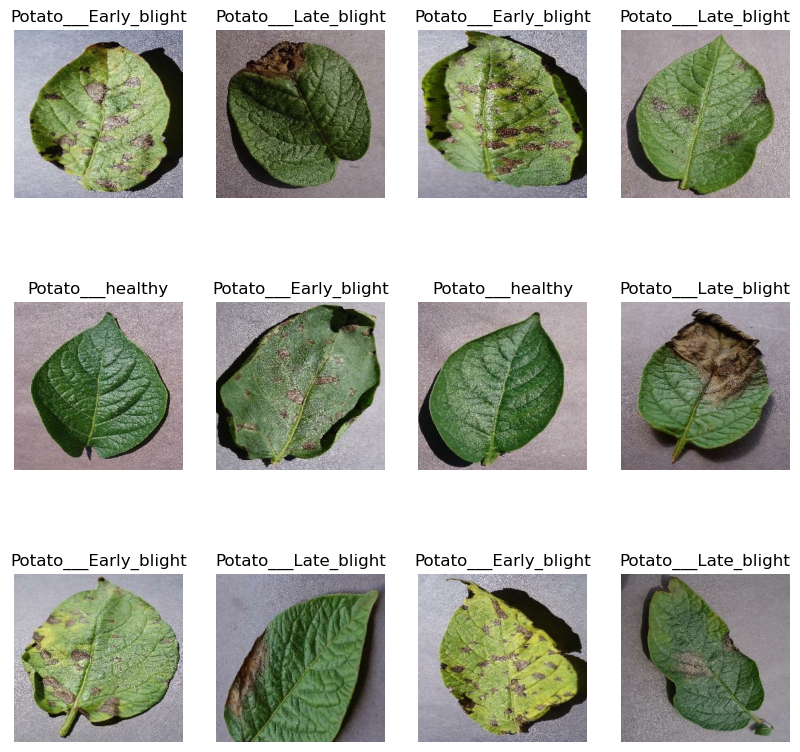

In [64]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# Train, Dev, Test 🙈 🙉 🙊

Now, we split the dataset like,

80% ==> Training
20% ==> 10% Validation, 10% Test

We have 32 batch for 2152 data. Every batch includes:
Number of data in a batch * .8

In [7]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [8]:
train_ds = dataset.take(54)
len(train_ds) # number of batchs (32*54 train data)

54

In [9]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [10]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [11]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [12]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [13]:
def get_dataset_partitions_tf(ds, train_split= 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

54

In [16]:
len(val_ds)

6

In [17]:
len(test_ds)

8

# Preprocessing 🔎

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Model Building 🔨

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])

model.build(input_shape = input_shape)

C:\Users\furka\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(
optimizer = 'adam',
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    epochs = EPOCH,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 531ms/step - accuracy: 0.4650 - loss: 0.9427 - val_accuracy: 0.4844 - val_loss: 0.8961
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 487ms/step - accuracy: 0.6169 - loss: 0.7958 - val_accuracy: 0.8021 - val_loss: 0.5478
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 508ms/step - accuracy: 0.7737 - loss: 0.4866 - val_accuracy: 0.8906 - val_loss: 0.3166
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 512ms/step - accuracy: 0.8648 - loss: 0.3348 - val_accuracy: 0.9531 - val_loss: 0.1957
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 518ms/step - accuracy: 0.8832 - loss: 0.2894 - val_accuracy: 0.9427 - val_loss: 0.2063
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 507ms/step - accuracy: 0.9240 - loss: 0.2195 - val_accuracy: 0.9323 - val_loss: 0.2426
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 517ms/step - accuracy: 0.9093 - loss: 0.2401 - val_accuracy: 0.9167 - val_loss: 0.2759
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 511ms/step - accuracy: 0.9169 - loss: 0.2262 - val_accu

In [25]:
score = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.9823 - loss: 0.0389


In [26]:
score

[0.04518371447920799, 0.98046875]

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [29]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

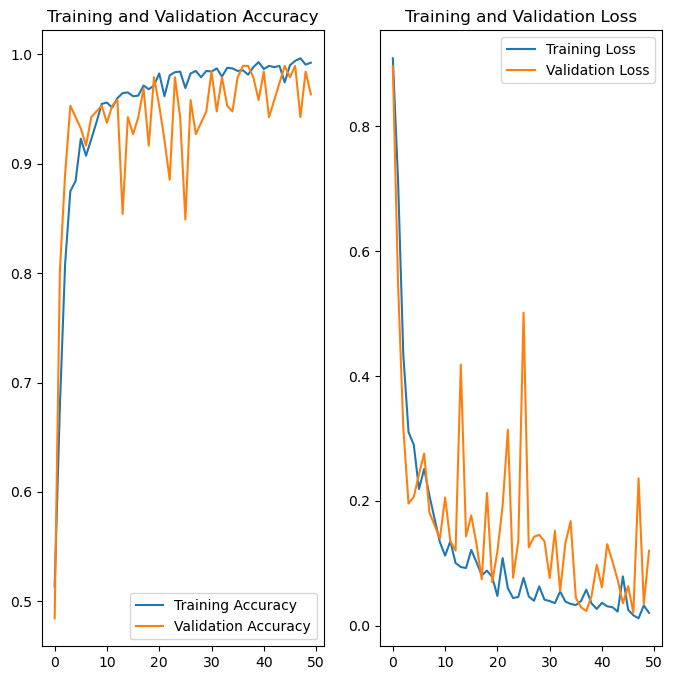

In [31]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), acc, label = 'Training Accuracy')
plt.plot(range(EPOCH), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCH), loss, label = 'Training Loss')
plt.plot(range(EPOCH), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

# Prediction ❓

First image to predict
Actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
Predicted label: Potato___Late_blight


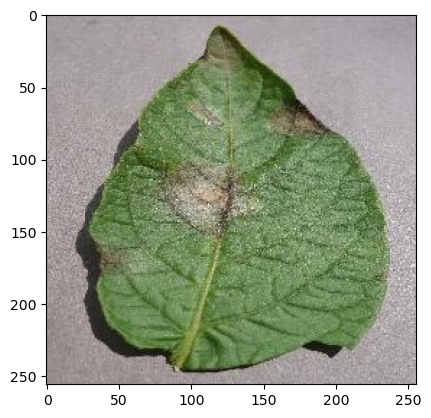

In [32]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


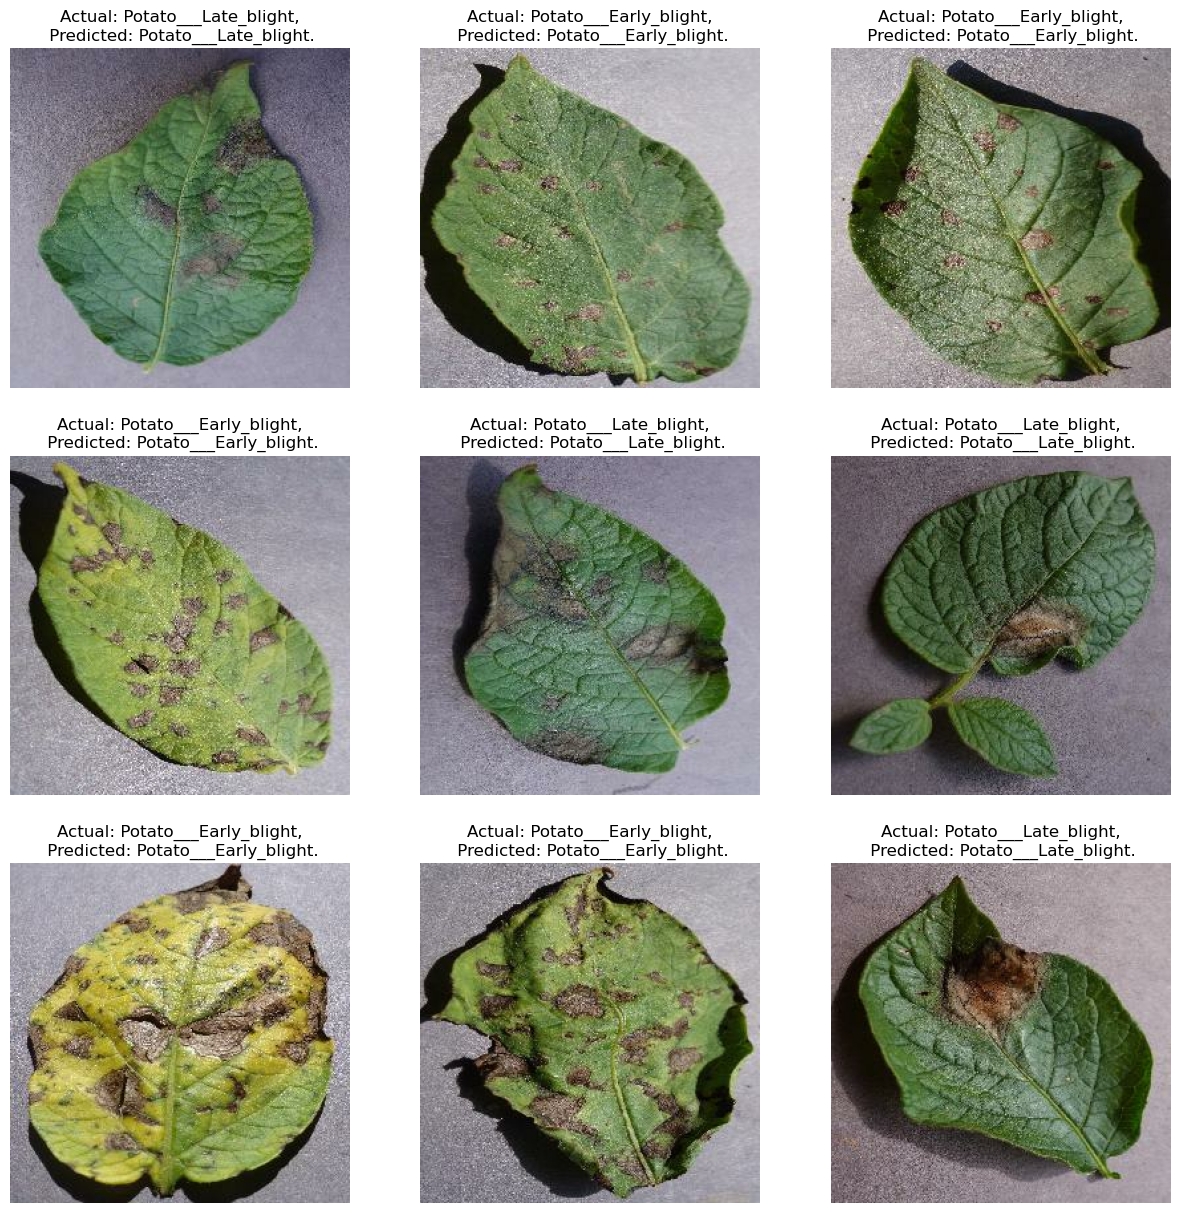

In [37]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.")
        
        plt.axis("off")

# Download the model 💾

In [71]:
import os
model_version = max([int(i) for i in os.listdir("../models/") + [0]]) + 1
model.export(f"../models/{model_version}") 

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


Saved artifact at '../models/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1801383920208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1801569175152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1801569483968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1801569484144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1801569483440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1801569602720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1801569604480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1801569599552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1801569606064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1801569603776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1801569607648: TensorSpec(shape=(), dty